In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os

%load_ext autoreload
%autoreload 2

# 1. Pre-process data

In [2]:
data_path = Path(os.getcwd()) / 'office'

output_path = data_path / 'output'
output_path.mkdir(parents=True, exist_ok=True)

imgs_fpaths = sorted((data_path / 'rgb').glob('*.png'))

cams_info_fpath = data_path / 'cams_info_no_extr.mat'
kp_fpath = data_path / 'kp.mat'
world_info_fpath = data_path / 'wrld_info.mat'

In [3]:
# Cleaning cams info

cams_info_raw = spio.loadmat(cams_info_fpath)['cams_info']
cams_info = []
for datapoint in cams_info_raw:
    img = datapoint[0][0][0][0]
    depth_map = datapoint[0][0][0][1]
    conf_map = datapoint[0][0][0][2]
    focal_length = datapoint[0][0][0][3][0][0]
    cams_info.append({'focal_length':focal_length, 'rgb':img, 'depth':depth_map, 'conf': conf_map})

In [4]:
# Cleaning sift keypoints and descriptions

kp= spio.loadmat(kp_fpath)
keys = list(set(kp.keys()) - {'__header__', '__version__', '__globals__'})
keys = sorted(keys, key=lambda x: int(x.split('_')[1][3:]))

sift = []
for key in keys:
    sift.append({'kp': kp[key][0][0][0], 'desc': kp[key][0][0][1]})

In [5]:
from utils import ImageNode
image_nodes = []

for i in range(len(cams_info)):
    image_nodes.append(ImageNode(
        idx=i,
        rgb=cams_info[i]['rgb'],
        keypoints=sift[i]['kp'],
        descriptors=sift[i]['desc'],
        depth_map=cams_info[i]['depth'],
        conf_map=cams_info[i]['conf'],
        focal_length=cams_info[i]['focal_length']
    ))

# 2. Compute point cloud

In [6]:
for node in image_nodes:
    node.camera_intrinsic = node.get_camera_intrinsic()
    node.point_cloud = node.get_point_cloud()

In [31]:
"""Show point clouds""";

# import open3d as o3d
# for i, node in enumerate(image_nodes):
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(node.point_cloud)
#     pcd.colors = o3d.utility.Vector3dVector(node.rgb.reshape(-1, 3))
#     o3d.visualization.draw_geometries([pcd])
#     # o3d.io.write_point_cloud(str(output_path / f"point_cloud_img{i}.ply"), pcd)

# 3. Match keypoints

In [147]:
def get_sift_matches(node1, node2, confidence_threshold=0.5, ratio_threshold=0.85):
    """Match SIFT descriptors between two ImageNodes, filtering by confidence and Lowe's ratio test."""
    
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    knn_matches = matcher.knnMatch(node1.descriptors, node2.descriptors, k=2)

    # Apply Lowe's ratio test and filter by confidence
    good_matches = []
    for m, n in knn_matches:
        # Check error ration between first and second match
        if m.distance < ratio_threshold * n.distance:
            kp1_idx = m.queryIdx
            kp2_idx = m.trainIdx

            # Get keypoint locations
            x1, y1 = node1.keypoints[kp1_idx]
            x2, y2 = node2.keypoints[kp2_idx]

            # Check confidence maps
            if (node1.conf_map[int(y1), int(x1)] > confidence_threshold and
                    node2.conf_map[int(y2), int(x2)] > confidence_threshold):
                good_matches.append(m)

    return good_matches


In [ ]:
def visualize_sift_matches(node1, node2, matches):
    keypoints1 = [cv2.KeyPoint(x[0], x[1], 1) for x in node1.keypoints]
    keypoints2 = [cv2.KeyPoint(x[0], x[1], 1) for x in node2.keypoints]

    node1_rgb_converted = (node1.rgb * 255).astype(np.uint8)  # Convert float to 8-bit
    node2_rgb_converted = (node2.rgb * 255).astype(np.uint8)

    # Draw matches
    output_image = cv2.drawMatches(
        node1_rgb_converted, keypoints1,
        node2_rgb_converted, keypoints2,
        matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

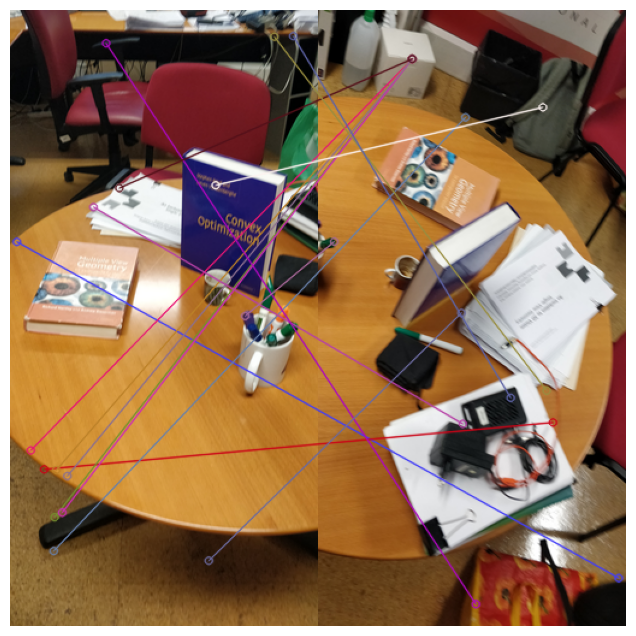

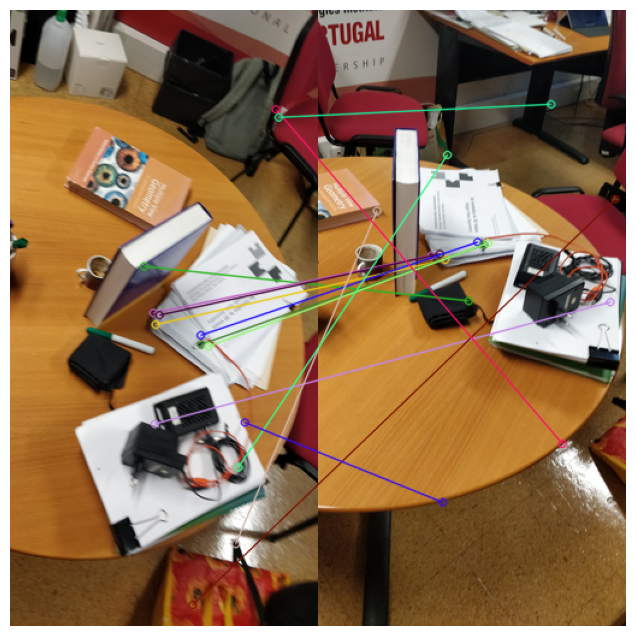

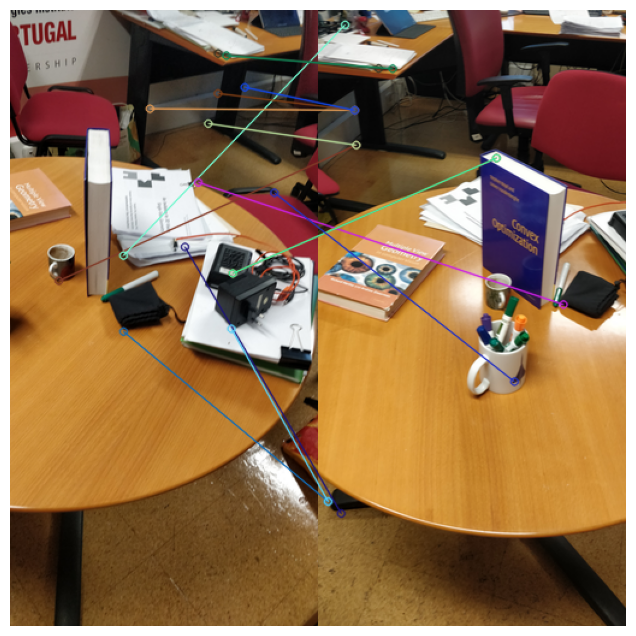

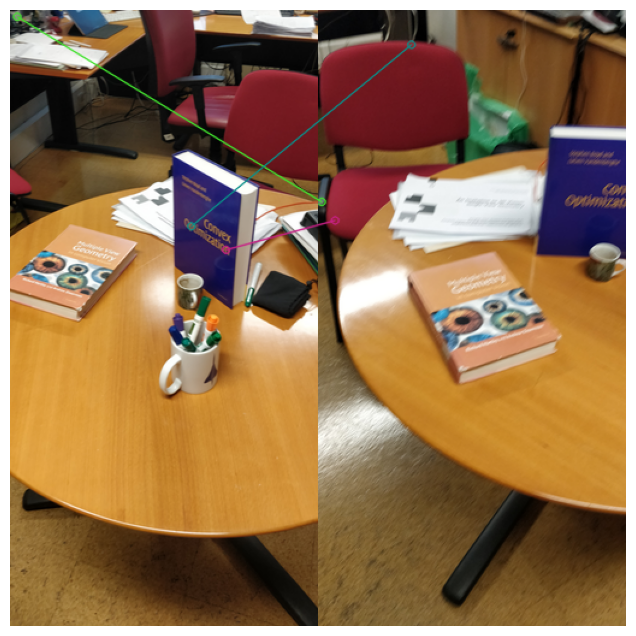

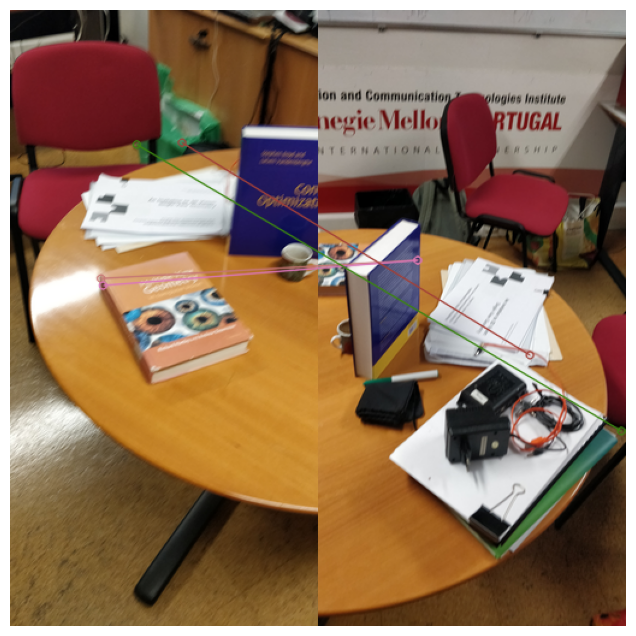

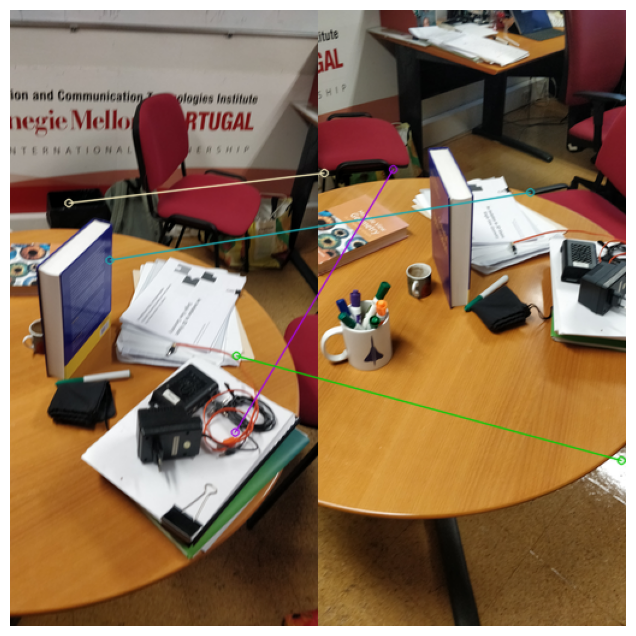

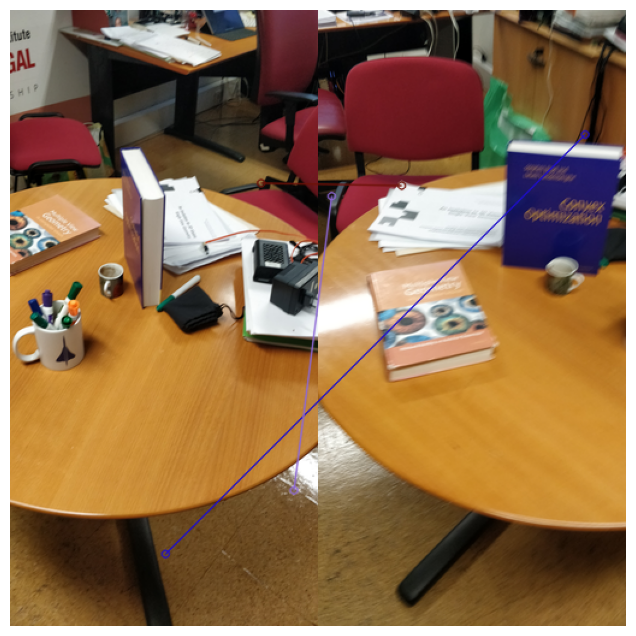

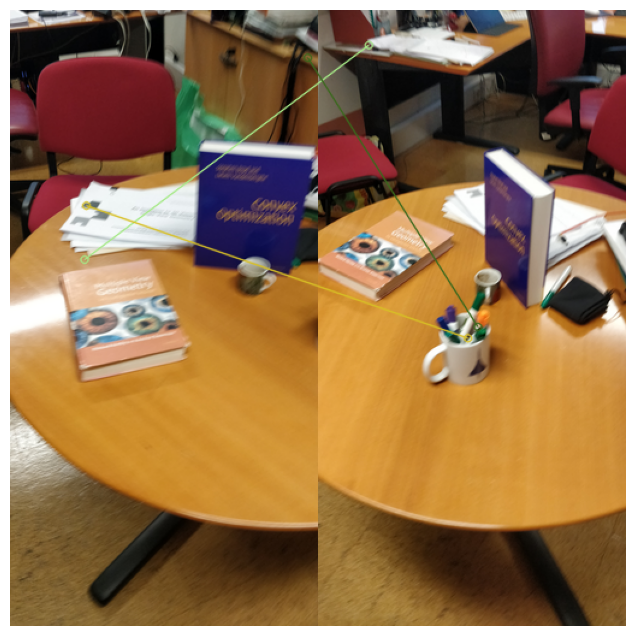

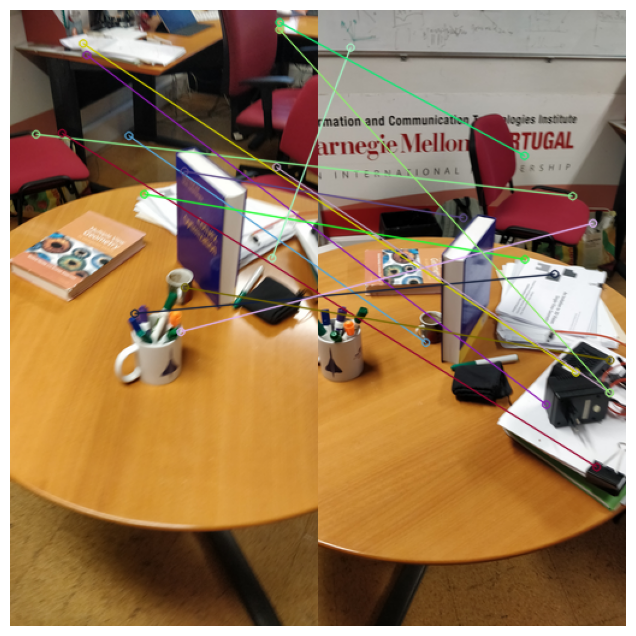

In [143]:
for i in range(len(image_nodes) - 1):
    node1 = image_nodes[i]
    node2 = image_nodes[i + 1]
    
    matches = get_sift_matches(node1, node2)
    visualize_sift_matches(node1, node2, matches)